In [11]:
import gymnasium as gym
from tensorflow.keras import models, layers, optimizers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
from collections import deque
import os
from time import strftime
import csv

In [12]:
class Logger:
    def __init__(self):
        # Create a unique log directory
        self.log_dir = f"log_{strftime("%Y_%m_%d-%H_%M_%S")}"
        os.makedirs(self.log_dir, exist_ok=True)

        # Paths for logging files
        self.rewards_log_path = os.path.join(self.log_dir, "training_rewards.csv")
        self.transitions_log_path = os.path.join(self.log_dir, "transitions.csv")
        self.evaluation_log_path = os.path.join(self.log_dir, "evaluation_rewards.csv")
        self.model_save_path = os.path.join(self.log_dir, "trained_model.keras")

        # Initialize the CSV log files
        with open(self.rewards_log_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["episode", "reward"])

        with open(self.transitions_log_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["episode", "state", "action", "next-state", "reward", "done", "truncated"])

        with open(self.evaluation_log_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["episode", "reward"])

    def log_reward(self, episode, reward):
        with open(self.rewards_log_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([episode, reward])

    def log_transition(self, episode, state, action, next_state, reward, done, truncated):
        with open(self.transitions_log_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([episode, state.tolist(), action, next_state.tolist(), reward, done, truncated])

    def save_model(self, model):
        model.save(self.model_save_path)

In [13]:
class ExponentialDecay:
    def __init__(self, initial_epsilon, decay_rate, min_epsilon):
        self.initial_epsilon = initial_epsilon
        self.current_epsilon = initial_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon

    def get_value(self):
        return max(self.current_epsilon, self.min_epsilon)

    def update(self):
        if self.current_epsilon > self.min_epsilon:
            self.current_epsilon *= self.decay_rate


class DQN:
    def __init__(
            self,
            main_model,
            target_model=None,
            epsilon=None,
            gamma=None,
            action_space=None,
            max_buffer=50000
    ) -> None:
        self.action_space = copy.deepcopy(action_space)
        self.epsilon = epsilon
        self.gamma = gamma
        self.buffer_replay = deque(maxlen=max_buffer)
        self.main_model = main_model
        self.target_model = target_model

    def select_action(self, state):
        if random.random() < self.epsilon.get_value():
            self.epsilon.update()
            return random.choice(self.action_space)
        else:
            return self.select_best_action(state)

    def select_best_action(self, state):
        q_values = self.main_model.predict(state[np.newaxis], verbose=0)
        return np.argmax(q_values)

    def store_transition(self, state, action, next_state, reward, done, truncated):
        self.buffer_replay.append((state, action, next_state, reward, done, truncated))

    def sample_minibatch(self, batch_size):
        indices = np.random.choice(len(self.buffer_replay), size=batch_size)
        return [self.buffer_replay[idx] for idx in indices]

    def train(self, batch_size, n_iterations=1):
        if len(self.buffer_replay) < batch_size:
            return

        for _ in range(n_iterations):
            minibatch = self.sample_minibatch(batch_size)
            states, actions, next_states, rewards, dones, truncates = map(np.array, zip(*minibatch))
            next_q_values = self.target_model.predict(next_states, verbose=0)
            q_targets = np.max(next_q_values, axis=-1)
            q_targets = rewards + (1 - (dones | truncates)) * q_targets * self.gamma
            current_q_values = self.main_model.predict(states, verbose=0)
            current_q_values[np.arange(batch_size), actions] = q_targets
            self.main_model.fit(states, current_q_values, epochs=1, batch_size=batch_size, verbose=0)

    def update_target_model(self, weights=None):
        if weights is not None:
            self.target_model.set_weights(weights)
        else:
            self.target_model.set_weights(self.main_model.get_weights())


def create_q_network(state_dim, action_dim):
    model = models.Sequential([
        layers.Input(shape=(state_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(action_dim)
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='huber')
    return model


def train_agent(env, agent, episodes, update_target_freq, logger=None):
    rewards = []

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        terminated = False

        while not terminated:
            action = agent.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            agent.store_transition(state, action, next_state, reward, done, truncated)
            agent.train(batch_size=32)
            terminated = done or truncated
            # Log transitions
            if logger:
                logger.log_transition(episode,state, action, next_state, reward, done, truncated)
                
            state = next_state
            total_reward += reward
        # Log rewards
        if logger:
            logger.log_reward(episode, total_reward)
            
        # Save the model
        if logger:
            logger.save_model(agent.main_model)
        
        # Update target network
        if episode % update_target_freq == 0:
            agent.update_target_model()

        rewards.append(total_reward)
        print(
            f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon.get_value():.2f}")

    return rewards



def evaluate_agent(env, agent, episodes, logger=None):
    rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        terminated = False

        while not terminated:
            action = agent.select_best_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            terminated = done or truncated
            # Log transitions
            if logger:
                logger.log_transition(episode,state, action, next_state, reward, done, truncated)
                
            state = next_state
            total_reward += reward
        # Log rewards
        if logger:
            logger.log_reward(episode, total_reward)
            
        rewards.append(total_reward)
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}")
    env.close()

    return rewards


def plot_rewards(rewards, title, save_fig=False):
    plt.plot(rewards, label='Total Reward per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title(title)
    if save_fig:
        plt.savefig(title + '_' + strftime("%Y_%m_%d_%H_%M_%S") +'_' + '.png')
    plt.legend()
    plt.show()

In [14]:
env = gym.make('LunarLander-v3')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n


Episode 1/6, Total Reward: -66.94, Epsilon: 0.66
Episode 2/6, Total Reward: -359.53, Epsilon: 0.48
Episode 3/6, Total Reward: -163.00, Epsilon: 0.39
Episode 4/6, Total Reward: -135.88, Epsilon: 0.33
Episode 5/6, Total Reward: -60.94, Epsilon: 0.27
Episode 6/6, Total Reward: -0.31, Epsilon: 0.22


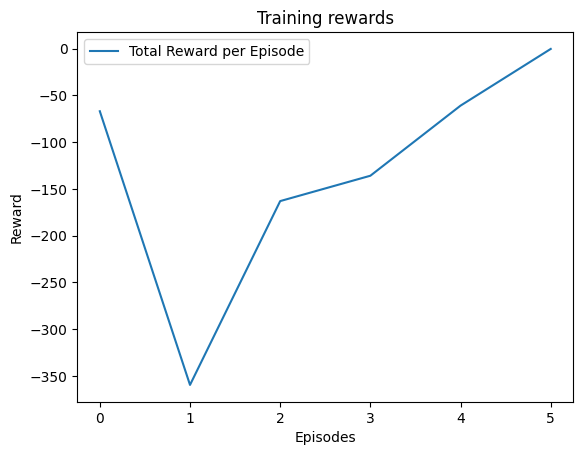

In [15]:
# Training cell
main_network = create_q_network(state_dim, action_dim)
target_network = create_q_network(state_dim, action_dim)
epsilon_schedule = ExponentialDecay(initial_epsilon=1.0, decay_rate=0.995, min_epsilon=0.01)

agent = DQN(
    main_model=main_network,
    target_model=target_network,
    epsilon=epsilon_schedule,
    gamma=0.99,
    action_space=list(range(action_dim))
)
logger = Logger()

training_episodes = 6
training_rewards = train_agent(env=env, agent=agent, episodes=training_episodes,update_target_freq=20 ,logger=logger)
plot_rewards(training_rewards, "Training rewards", True)


In [16]:
# Uncomment code to load model and initialize the agent
#agent = DQN(main_model=tf.keras.models.load_model('model_name.keras'))
#logger = Logger()


Episode 1/6, Total Reward: -322.46
Episode 2/6, Total Reward: -545.32
Episode 3/6, Total Reward: 7.52
Episode 4/6, Total Reward: -40.67
Episode 5/6, Total Reward: -598.18
Episode 6/6, Total Reward: -337.33


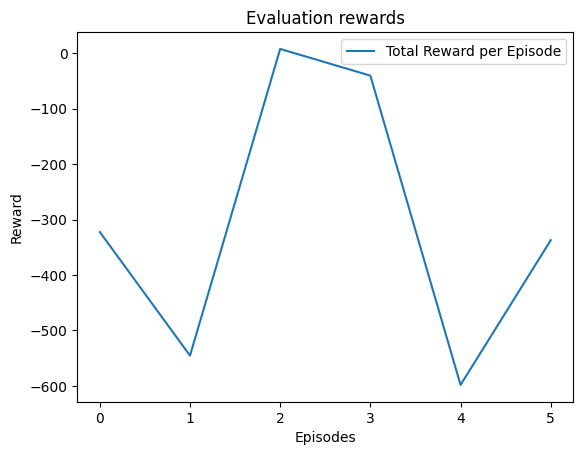

In [17]:
# Evaluation cell
evaluation_episodes = 6
evaluate_rewards = evaluate_agent(env=env, agent=agent, episodes=evaluation_episodes, logger=logger)
plot_rewards(evaluate_rewards, "Evaluation rewards", True)

In [18]:
# Uncomment to see live action
# env2 = gym.make('LunarLander-v3', render_mode="human")
# evaluate_rewards = evaluate_agent(env=env2, agent=agent, episodes=1, logger=None)